In [1]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit

import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
clist = ['#c21f30', '#ffffff', '#1677b3']
new_cmap = LinearSegmentedColormap.from_list('wb', clist)

plt.style.use('default')
sns.set_color_codes()

from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42

rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']
rcParams['mathtext.fontset'] = 'custom'
rcParams['mathtext.cal'] = 'Arial'
rcParams['mathtext.it'] = 'Arial'
rcParams['mathtext.rm'] = 'Arial'

In [2]:
obinfo = pd.read_csv('ObInfo.txt')
data = pd.read_csv('BurstMJD.txt')
data['wt'] = np.append(0, np.diff(data.mjd*24*60*60))
data['date'] = 0
first_burst = np.append(0, np.append(data.loc[(data.wt>1e4)].index.values, len(data)-1))
k = 0
for i in range(len(first_burst)-1):
    data.loc[first_burst[i]:first_burst[i+1], 'date'] = k
    k += 1

## Waiting Time

ALL: bigPeak - 444.49+-1163.87


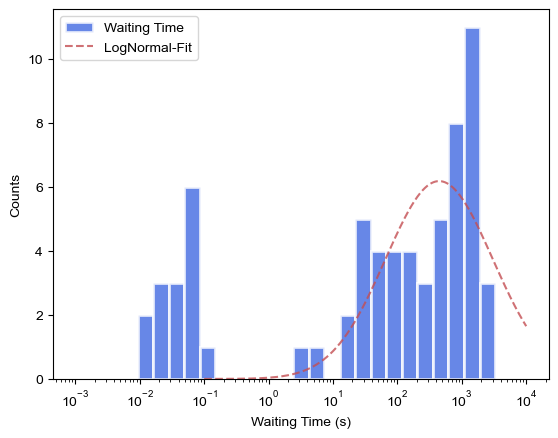

In [3]:
from scipy import stats

def lognorm(x, a, mu, sigma):
    return a * np.exp(-((np.log(x) - mu)**2) / (2* sigma**2)) / (sigma * x * np.sqrt(2*np.pi))

def cal_mode_merr(mu, sigma, mu_err, sigma_err):
    mode = np.exp(mu-sigma**2)
    merr = mode*np.sqrt(mu_err**2+4*sigma**2*sigma_err**2)
    return mode, merr

waiting_time = []
for i in set(data.date.values):
    waiting_time = np.append(waiting_time, np.diff(np.sort(data.loc[data.date==i].mjd*24*60*60)))
a = plt.hist(waiting_time, bins=np.logspace(-3, 4, 30), color='royalblue', lw=2, label='Waiting Time', alpha=0.8, edgecolor='white')

time_bin, time_count = a[1][:-1] + np.diff(a[1])/2, a[0]
b = time_bin[time_bin>1]
c = time_count[time_bin>1]
popt, pcov = curve_fit(lognorm, b, c)
p, pe = cal_mode_merr(popt[1], popt[2], np.sqrt(pcov[1][1]), np.sqrt(pcov[2][2]))
print('ALL: bigPeak - {}+-{}'.format(np.round(p, 2), np.round(pe, 2)))
x = np.logspace(-1, 4, num=1000, base=10)
y = lognorm(x, *popt)
plt.plot(x, y, 'r', linewidth=1.5, ls='--', alpha=0.8, label='LogNormal-Fit')

plt.xlabel('Waiting Time (s)')
plt.ylabel('Counts')
plt.xscale('log')
plt.legend(loc='upper left')
# plt.savefig('Figure/WaitingTime', dpi=300, bbox_inches='tight')
plt.show()

## Lomb-Scargle

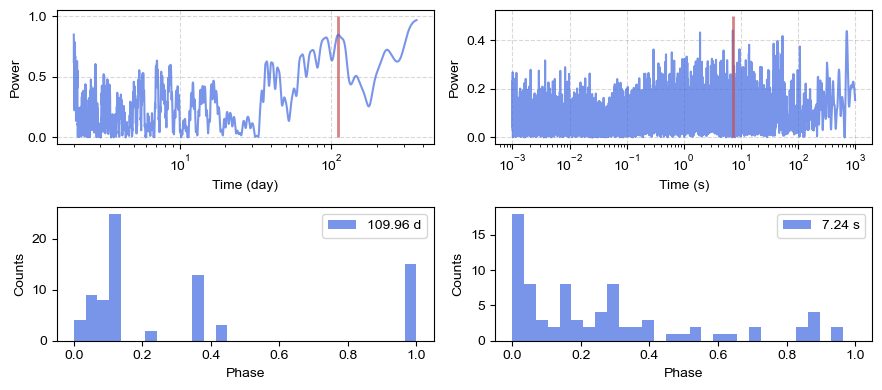

In [4]:
from scipy import signal
plt.figure(figsize=(9, 4))
plt.subplot(221)
time_series = data.mjd.values - data.mjd.values.min()
tt = np.logspace(np.log10(2), np.log10(365), 10000, base=10)
pwr = signal.spectral.lombscargle(time_series, [1]*len(time_series), 2*np.pi/tt, normalize=True)
plt.vlines(109.96, 0, 1, color='r', alpha=0.7, lw=2)
plt.plot(tt, pwr, alpha=0.7, color='royalblue')
plt.xlabel('Time (day)')
plt.ylabel('Power')
plt.xscale('log')
plt.grid(ls='--', color='gray', alpha=0.3)

plt.subplot(223)
plt.hist((time_series / 109.96) % 1, bins=np.linspace(0, 1, 30), color='royalblue', alpha=0.7, label='109.96 d')
plt.xlabel('Phase')
plt.ylabel('Counts')
plt.legend()

plt.subplot(222)
time_series = []
for i in set(data.date.values):
    time_series = np.append(time_series, (data.loc[data.date==i].mjd-data.loc[data.date==i].mjd.min())*24*60*60)
tt = np.logspace(-3, 3, 10000, base=10)
pwr = signal.spectral.lombscargle(time_series, [1]*len(time_series), 2*np.pi/tt, normalize=True)
plt.plot(tt, pwr, alpha=0.7, color='royalblue')
plt.vlines(tt[np.argmax(pwr)], 0, 0.5, color='r', alpha=0.7, lw=2)
plt.xlabel('Time (s)')
plt.ylabel('Power')
plt.xscale('log')
plt.grid(ls='--', color='gray', alpha=0.3)

plt.subplot(224)
plt.hist((time_series / tt[np.argmax(pwr)]) % 1, bins=np.linspace(0, 1, 30), 
         color='royalblue', alpha=0.7, label='{} s'.format(np.round(tt[np.argmax(pwr)], 2)))
plt.xlabel('Phase')
plt.ylabel('Counts')
plt.legend()

plt.tight_layout()
# plt.savefig('Figure/Lomb-Scargle', dpi=300, bbox_inches='tight')
plt.show()

## Phase-Folding

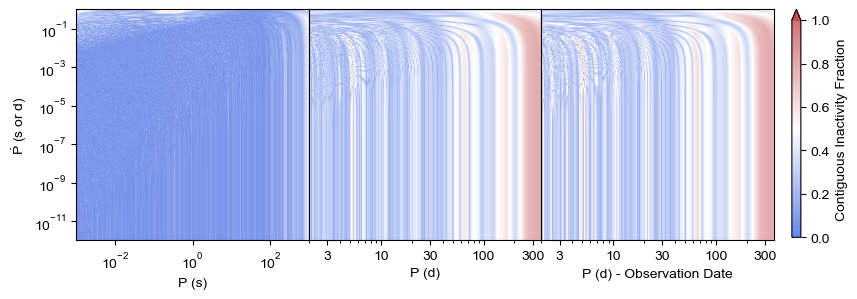

In [5]:
import re
from astropy.time import Time
clist = ['royalblue', 'white', 'r']
new_cmap = LinearSegmentedColormap.from_list('wb', clist)

time_series = []
for i in set(data.date.values):
    time_series = np.append(time_series, (data.loc[data.date==i].mjd-data.loc[data.date==i].mjd.min())*24*60*60)
time_series = np.diff(np.sort(time_series))
Input_array = time_series

##### FAST Period #####
P0 = np.logspace(-3, 3, 2000)
P1 = np.logspace(-12, 0, 2000)

xx, yy = np.meshgrid(P0, P1)
a = np.sort((Input_array/(xx[:,:,np.newaxis] + Input_array*yy[:,:,np.newaxis]))%1, axis=-1)
a = np.max(np.diff(np.sort(np.append(a, -1+a[:,:,-1][:,:,np.newaxis], axis=-1), axis=-1), axis=-1), axis=-1)

fig = plt.figure(figsize=(9, 3))
plt.subplots_adjust(wspace=0, hspace=0)

plt.subplot(131)
pcm = plt.pcolormesh(xx, yy, a, vmin=0, vmax=1, cmap=new_cmap, shading='auto', alpha=0.8)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('P (s)')
plt.ylabel('$\\dot{P}$ (s or d)')

##### Slow Period #####
time_series = np.diff(np.sort(data.mjd.values - data.mjd.values.min()))
Input_array = time_series

P0 = np.logspace(np.log10(2), np.log10(365), 2000)
P1 = np.logspace(-12, 0, 2000)

xx, yy = np.meshgrid(P0, P1)
a = np.sort((Input_array/(xx[:,:,np.newaxis] + Input_array*yy[:,:,np.newaxis]))%1, axis=-1)
a = np.max(np.diff(np.sort(np.append(a, -1+a[:,:,-1][:,:,np.newaxis], axis=-1), axis=-1), axis=-1), axis=-1)

plt.subplot(132)
pcm = plt.pcolormesh(xx, yy, a, vmin=0, vmax=1, cmap=new_cmap, shading='auto', alpha=0.8)
plt.xscale('log')
plt.yscale('log')
plt.xticks([3, 10, 30, 100, 300], [3, 10, 30, 100, 300])
plt.yticks([])
plt.xlabel('P (d)')

##### ObSession Period #####
plt.subplot(133)
t = Time(['-'.join(re.search(r'(\d{4})(\d{2})(\d{2})', str(i)).groups()) for i in obinfo.Date.values], format='isot', scale='utc')
time_series = np.diff(np.sort(t.mjd - t.mjd.min()))
Input_array = time_series

P0 = np.logspace(np.log10(2), np.log10(365), 2000)
P1 = np.logspace(-12, 0, 2000)

xx, yy = np.meshgrid(P0, P1)
a = np.sort((Input_array/(xx[:,:,np.newaxis] + Input_array*yy[:,:,np.newaxis]))%1, axis=-1)
a = np.max(np.diff(np.sort(np.append(a, -1+a[:,:,-1][:,:,np.newaxis], axis=-1), axis=-1), axis=-1), axis=-1)

pcm = plt.pcolormesh(xx, yy, a, vmin=0, vmax=1, cmap=new_cmap, shading='auto', alpha=0.8)
plt.xscale('log')
plt.yscale('log')
plt.xticks([3, 10, 30, 100, 300], [3, 10, 30, 100, 300])
plt.yticks([])
plt.xlabel('P (d) - Observation Date')
fig.subplots_adjust(right=0.9)

l, b, w, h = 0.92, 0.12, 0.01, 1 - 2*0.12
cbar_ax = fig.add_axes([l, b, w, h]) 
cbar = plt.colorbar(pcm, cax=cbar_ax, extend='max')
cbar.ax.set_ylabel('Contiguous Inactivity Fraction')

# plt.savefig('Figure/Phase-Folding-2', dpi=500, bbox_inches='tight')
plt.show()

## Weibull Distribution

In [6]:
import emcee
import scipy.special as sp
from multiprocessing import Pool

waiting_time = []
for i in set(data.date.values):
    waiting_time = np.append(waiting_time, np.diff(np.sort(data.loc[data.date==i].mjd*24)))

def post_waitime(p, x):
    k = p[0]
    theta = p[1]
    if k <= 0 or theta <= 0: return -1e50
    likelihood = 0
    lam = 1 / (theta * sp.gamma(1 + 1/k))
    for i in range(len(x)):
        likelihood += np.log(k/lam) + (k-1)*np.log(x[i]/lam) - (x[i]/lam)**k
    if np.isnan(likelihood):
        likelihood = 0
    return likelihood

ndim = 2
nwalkers = 100

p0 = np.zeros((nwalkers, ndim))
p0[:,0] = np.random.rand(nwalkers)*0.5+0.5
p0[:,1] = np.random.rand(nwalkers)*3+1
with Pool() as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, post_waitime, args=[waiting_time[(waiting_time!=0)]], pool=pool)
    sampler.reset()
    pos, prob, state = sampler.run_mcmc(p0, 1000, progress=True)
    sampler.reset()
    sampler.run_mcmc(pos, 1000, progress=True)

result = sampler.chain.reshape([-1, ndim])

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:19<00:00, 51.95it/s]


In [7]:
p0 = np.zeros((nwalkers, ndim))
p0[:,0] = np.random.rand(nwalkers)*0.5+0.5
p0[:,1] = np.random.rand(nwalkers)*3+1

with Pool() as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, post_waitime, args=[waiting_time[(waiting_time>1/60/60)]], pool=pool)
    sampler.reset()
    pos, prob, state = sampler.run_mcmc(p0, 1000, progress=True)
    sampler.reset()
    sampler.run_mcmc(pos, 1000, progress=True)

result_2 = sampler.chain.reshape([-1, ndim])

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:15<00:00, 66.13it/s]


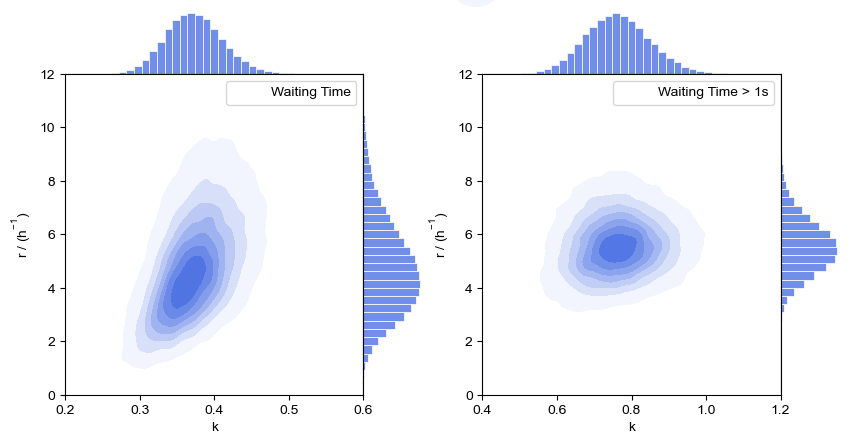

In [8]:
from matplotlib import gridspec
clist = ['white', 'royalblue']
new_cmap = LinearSegmentedColormap.from_list('wb', clist)

plt.figure(figsize=(10, 5))
plt.subplots_adjust(wspace=0, hspace=0)
gs = gridspec.GridSpec(6, 13)

samp_data = pd.DataFrame({'k':result[:, 0], 'r':result[:, 1]})
ax1 = plt.subplot(gs[0:1, 0:5])
g = sns.histplot(data=samp_data, x='k', color='royalblue', edgecolor='white', ax=ax1, stat='density', bins=np.linspace(0.2, 0.6, 40))
sns.despine(right=True, left=True, top=True, ax=ax1)
plt.xlabel('')
plt.ylabel('')
plt.xticks([])
plt.yticks([])
plt.xlim(0.2, 0.6)

ax1 = plt.subplot(gs[1:6, 0:5])
g = sns.kdeplot(data=samp_data, x='k', y='r', levels=8, cmap=new_cmap, fill=True, ax=ax1, label='Waiting Time')
plt.ylabel('${r}\ /\ (\mathrm{h}^{-1})$')
plt.xlim(0.2, 0.6)
plt.ylim(0, 12)
plt.legend(loc='upper right')

ax1 = plt.subplot(gs[1:6, 5:6])
g = sns.histplot(data=samp_data, y='r', color='royalblue', edgecolor='white', ax=ax1, stat='density', bins=np.linspace(0, 12, 40))
sns.despine(right=True, bottom=True, top=True, ax=ax1)
plt.xlabel('')
plt.ylabel('')
plt.xticks([])
plt.yticks([])
plt.ylim(0, 12)

samp_data = pd.DataFrame({'k':result_2[:, 0], 'r':result_2[:, 1]})
ax1 = plt.subplot(gs[0:1, 7:12])
g = sns.histplot(data=samp_data, x='k', color='royalblue', edgecolor='white', ax=ax1, stat='density', bins=np.linspace(0.4, 1.2, 40))
sns.despine(right=True, left=True, top=True, ax=ax1)
plt.xlabel('')
plt.ylabel('')
plt.xticks([])
plt.yticks([])
plt.xlim(0.4, 1.2)

ax1 = plt.subplot(gs[1:6, 7:12])
g = sns.kdeplot(data=samp_data, x='k', y='r', levels=8, cmap=new_cmap, fill=True, ax=ax1, label='Waiting Time > 1s')
plt.ylabel('${r}\ /\ (\mathrm{h}^{-1})$')
plt.xlim(0.4, 1.2)
plt.ylim(0, 12)
plt.legend(loc='upper right')

ax1 = plt.subplot(gs[1:6, 12:13])
g = sns.histplot(data=samp_data, y='r', color='royalblue', edgecolor='white', ax=ax1, stat='density', bins=np.linspace(0, 12, 40))
sns.despine(right=True, bottom=True, top=True, ax=ax1)
plt.xlabel('')
plt.ylabel('')
plt.xticks([])
plt.yticks([])
plt.ylim(0, 12)

# plt.savefig('Figure/Weibull-1s.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()